In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv
/kaggle/input/iterativestratification/.travis.yml
/kaggle/input/iterativestratification/setup.cfg
/kaggle/input/iterativestratification/LICENSE
/kaggle/input/iterativestratification/.gitignore
/kaggle/input/iterativestratification/README.md
/kaggle/input/iterativestratification/setup.py
/kaggle/input/iterativestratification/tests/test_ml_stratifiers.py
/kaggle/input/iterativestratification/tests/__init__.py
/kaggle/input/iterativestratification/iterstrat/ml_stratifiers.py
/kaggle/input/iterativestratification/iterstrat/__init__.py


# 1. EXPLORATORY DATA ANALYSIS (EDA)

* we are being asked to predict if the person has one or more of any of the three medical conditions (Class 1), or none of the three medical conditions (Class 0)
* The class 1 is further divided into 3 more categoreis, we actually do not know much about the actual names of these categories, but according to the data, these are **(B,D and G)**
* 

In [2]:
greeks = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")
sample_submission = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')

greeks.shape,sample_submission.shape,train.shape,test.shape

((617, 6), (5, 3), (617, 58), (5, 57))

**greeks.shape ->** has 617 rows and 6 columns

**sample_submission.shape ->** has 5 rows and 3 columns

**train.shape ->** has 617 rows and 58 columns

**test.shape ->** has 5 rows and 57 columns


**you can see that greeks df has exact same number of rows like train df**

Moreover, from given dataset we know :

* **train.csv** - inside this training set. we have :

   **Id -** Unique identifier for each observation.
   
   **AB-GL -** Fifty-six anonymized health characteristics. All              are numeric except for EJ, which is categorical.
   
   **Class -** A binary target:  1 indicates the subject has been            diagnosed with one of the three conditions,  0                 indicates they have not.
   
* **test.csv -** The test set. our goal is to predict the probability that a subject in this set belongs to each of the two classes.

* **greeks.csv -** Supplemental metadata, only available for the training set.

     **Alpha -** Identifies the type of age-related condition, if            present.
     
     **A -** No age-related condition. Corresponds to class  0
     
     **B, D, G -** The three age-related conditions.Correspond to class  1
 .
 
     * **Beta, Gamma, Delta** - Three experimental characteristics.
     
     * **Epsilon** - The date the data for this                           subject was collected. Note that all                           of the data in the test set was                               collected after the training set was                            collected.

In [3]:
train.head(2)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0


In [4]:
test.head(2)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
greeks.head(2)

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown


In [6]:
sample_submission.head(2)

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5


in both train and test df you can see that all the columns from **AB-GL** contains values of **independent variables(X)** and the **Class** column in train df is our **dependant variable (y)** 
see that, the **Class** column or **dependant variable (y)** is missing in test df because we will be using test df for making predictions on **dependant variable (y)**

# Let's see the ratio of positive and negative samples in our dataset

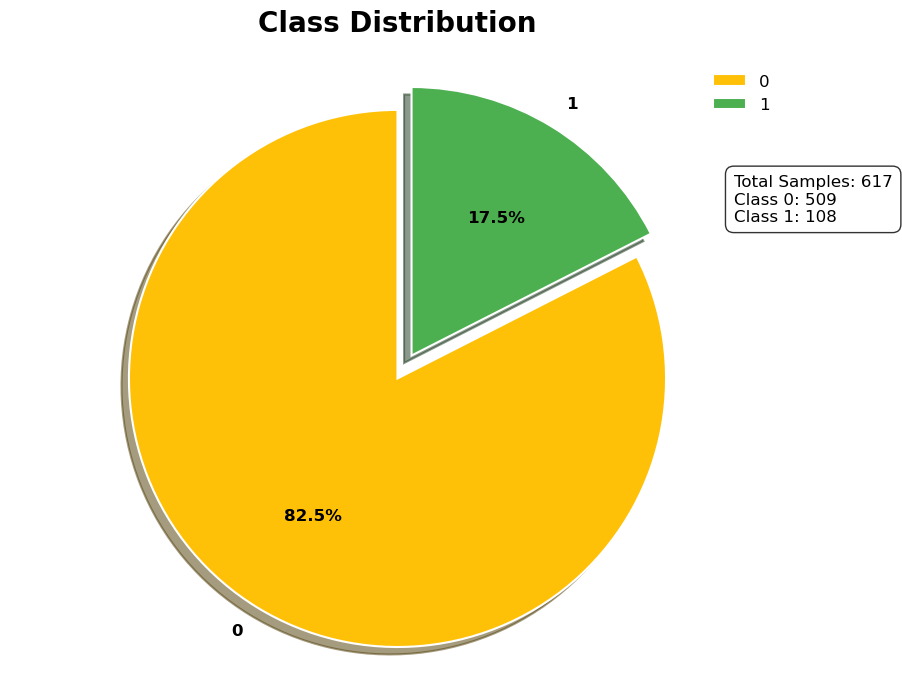

In [7]:
import matplotlib.pyplot as plt

# Define class counts and labels
class_counts = train.Class.value_counts()
class_labels = class_counts.index

# Define custom colors
colors = ['#FFC107', '#4CAF50']

# Define pie chart parameters
explode = (0.1, 0)
shadow = True
textprops = {'fontsize': 12, 'fontweight': 'bold'}

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Generate pie chart
wedges, texts, autotexts = ax.pie(class_counts, labels=class_labels, colors=colors,
                                  autopct='%1.1f%%', startangle=90,
                                  explode=explode, shadow=shadow, textprops=textprops,
                                  wedgeprops={'edgecolor': 'white', 'linewidth': 1.5})

# Set plot properties
plt.axis('equal')
plt.title('Class Distribution', fontsize=20, fontweight='bold', pad=20)
plt.legend(loc='upper right', fontsize=12, frameon=False)

# Add additional text
label_y = 0.5
label_x = 1.2
label_text = 'Total Samples: {}\nClass 0: {}\nClass 1: {}'.format(sum(class_counts), class_counts[0], class_counts[1])
ax.text(label_x, label_y, label_text, fontsize=12, bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

# Display the plot
plt.show()


The above code generates a pie chart with custom colors, labels, and additional text, representing the class distribution based on the class counts obtained from the training dataset.from the generated pie chart we can see that we have **big class imbalance problem here,we've got 82.5% samples for class 0 and 17.5% for class 1**

In [8]:
missing_values_cols = train.isna().sum()[train.isna().sum() > 0].index.to_list()

print("Training Dataset Missing Values\n")

for feature in missing_values_cols:
    print(
        feature + "\t",
        str(train[feature].isna().sum()) + "\t",
        f"{train[feature].isna().sum() / len(train):.1%}" + "\t",
        f"{train[feature].dtype}",
    )


Training Dataset Missing Values

BQ	 60	 9.7%	 float64
CB	 2	 0.3%	 float64
CC	 3	 0.5%	 float64
DU	 1	 0.2%	 float64
EL	 60	 9.7%	 float64
FC	 1	 0.2%	 float64
FL	 1	 0.2%	 float64
FS	 2	 0.3%	 float64
GL	 1	 0.2%	 float64


The code above checks for missing values in the training dataset and prints the feature names, the corresponding count of missing values, the percentage of missing values, and the data type for each feature. The output shows the features with their respective counts and percentages of missing values in the dataset.

In [9]:
#Thanks Raddar
#https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/413198
#convert values to int by finding their denominators
    
int_denominators = {
    'AB': 0.004273,
    'AF': 0.00242,
    'AH': 0.008709,
    'AM': 0.003097,
    'AR': 0.005244,
    'AX': 0.008859,
    'AY': 0.000609,
    'AZ': 0.006302,
    'BC': 0.007028,
    'BD ': 0.00799,
    'BN': 0.3531,
    'BP': 0.004239,
    'BQ': 0.002605,
    'BR': 0.006049,
    'BZ': 0.004267,
    'CB': 0.009191,
    'CC': 6.12e-06,
    'CD ': 0.007928,
    'CF': 0.003041,
    'CH': 0.000398,
    'CL': 0.006365,
    'CR': 7.5e-05,
    'CS': 0.003487,
    'CU': 0.005517,
    'CW ': 9.2e-05,
    'DA': 0.00388,
    'DE': 0.004435,
    'DF': 0.000351,
    'DH': 0.002733,
    'DI': 0.003765,
    'DL': 0.00212,
    'DN': 0.003412,
    'DU': 0.0013794,
    'DV': 0.00259,
    'DY': 0.004492,
    'EB': 0.007068,
    'EE': 0.004031,
    'EG': 0.006025,
    'EH': 0.006084,
    'EL': 0.000429,
    'EP': 0.009269,
    'EU': 0.005064,
    'FC': 0.005712,
    'FD ': 0.005937,
    'FE': 0.007486,
    'FI': 0.005513,
    'FR': 0.00058,
    'FS': 0.006773,
    'GB': 0.009302,
    'GE': 0.004417,
    'GF': 0.004374,
    'GH': 0.003721,
    'GI': 0.002572
}
for k, v in int_denominators.items():
    train[k] = np.round(train[k]/v,1)

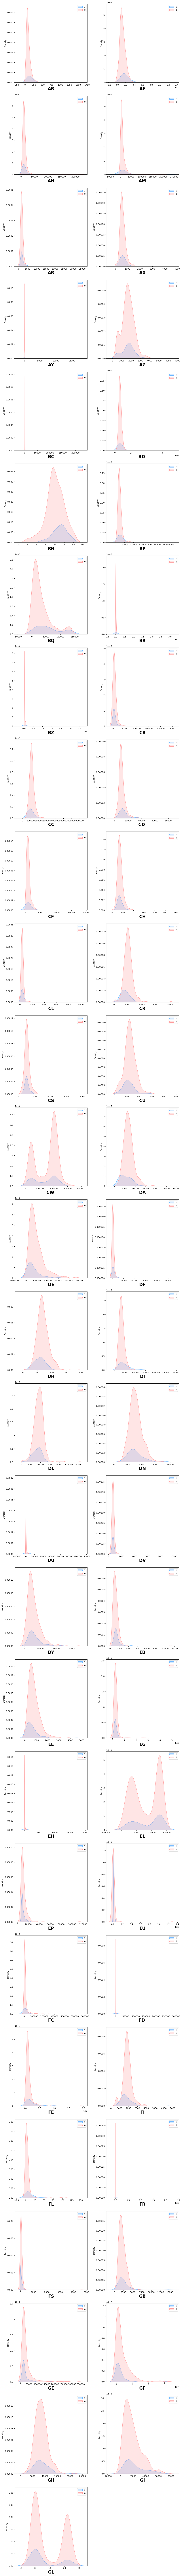

In [10]:
#BN is likely Age feature
import seaborn as sns

numerical_features = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ',
                      'BC', 'BD ', 'BN', 'BP', 'BQ', 'BR', 'BZ',
                      'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW ',
                      'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
                      'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU',
                      'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS',
                      'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
categorical_features = ['EJ']
features = numerical_features + categorical_features

# 'BD ', 'CD ', 'CW ', 'FD ' all have spaces after the column name, including in the test set

num_plots = len(numerical_features)
num_cols = 2  # Maximum number of columns in each row
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))
colors = ['#ff9999', '#66b3ff']  # Custom colors for each graph (2 classes)

for i, feature in enumerate(numerical_features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    sns.kdeplot(data=train, x=feature, hue='Class', fill=True, ax=ax, palette=colors)
    ax.set_xlabel(feature, fontweight='bold', fontsize=20)
    classes = train['Class'].unique()
    legend_labels = [str(c) for c in classes]
    ax.legend(labels=legend_labels)

if num_plots < num_rows * num_cols:
    for i in range(num_plots, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


**The code above generates a grid of subplots using Seaborn library to visualize the kernel density estimation (KDE) plots for each numerical feature in the 'train' dataset. The plots are grouped by the 'Class' variable.
In the first graph, representing feature 'AB', the KDE plot for 'Class' 0 shows a high peak in density above 0.007, with the x-axis ranging from 0 to just above 250. On the other hand, the KDE plot for 'Class' 1 starts from around -100 and extends to nearly 600, with the highest density peak occurring around 120. This difference in density and range between the two classes indicates variations in the distribution and characteristics of the 'AB' feature based on the 'Class' variable. it's difficult to explain each and every graph using text,if you understand the explanation of 'AB' feature then try to interpret all other graphs manually for better in-depth  understanding of the given dataset**

The values on the x-axis represent the values of the numerical feature being plotted. In the context of the provided code, each graph represents the KDE plot for a specific numerical feature from the 'train' dataset.

For example, in the first graph where the feature is 'AB', the x-axis values represent the range of values present in the 'AB' feature of the dataset. The specific values on the x-axis indicate the potential range of 'AB' values, and the density of the KDE plot shows how the values are distributed within that range.

The x-axis provides a visual representation of the values taken by the numerical feature, allowing us to observe patterns, distributions, and differences between different classes or groups.

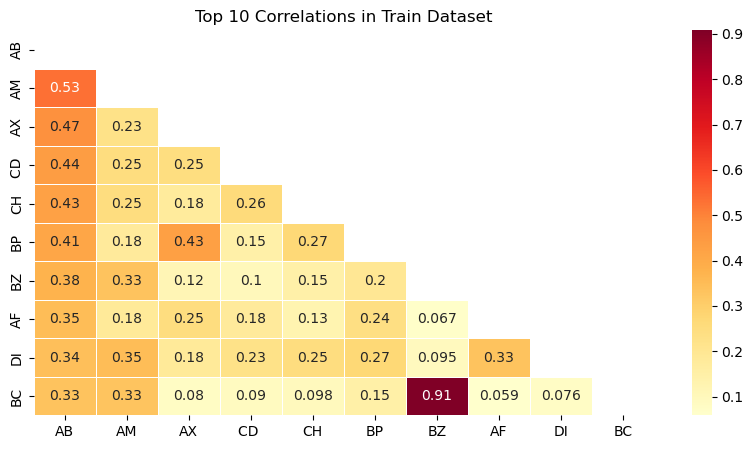

In [11]:
import random

random_num_cols = random.sample(numerical_features, k=10)

def plot_top_correlations(df, n, title_name='Top Correlations'):
    # Calculate correlation between all variables
    corr = df.corr()

    # Select variables having highest absolute correlation
    top_corr_cols = corr.abs().nlargest(n, columns=corr.columns).index
    top_corr = corr.loc[top_corr_cols, top_corr_cols]

    fig, axes = plt.subplots(figsize=(10, 5))
    mask = np.zeros_like(top_corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(top_corr, mask=mask, linewidths=.5, cmap='YlOrRd', annot=True)
    plt.title(title_name)
    plt.show()

# Plot heatmap of top 12 correlations in training data
plot_top_correlations(train[numerical_features], 10, 'Top 10 Correlations in Train Dataset')


In above code, we randomly select 10 numerical features from the numerical_features list and pass them to the plot_top_correlations() function. The function calculates the correlation matrix and selects the top correlated variables. It then generates a heatmap using seaborn's heatmap() function with annotations and a color map of 'YlOrRd'. Finally, the heatmap is displayed with the specified title.


for example,A correlation coefficient of 0.53 between variables AB and AM in above graph indicates a moderate positive correlation between the two variables. This means that as the values of variable AB increase, the values of variable AM tend to increase as well, and vice versa. The strength of the correlation can be interpreted as moderate, indicating a noticeable but not extremely strong relationship between the two variables.

# 2. Modeling

in code below,

I calculate the weights based on the inverse of the log loss for each fold (weights = [1 / loss for loss in fold_losses]). Then, I normalize the weights so that they sum up to 1 (total_weight = sum(weights) and weights = [weight / total_weight for weight in weights]).

The submission is generated by summing the weighted predictions from each fold (preds += weight * clf.predict_proba(test_df_selected)[:, 1]) and saving the result in the submission DataFrame. The resulting submission DataFrame is then saved to a CSV file.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
import warnings

# Ignore the specific UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

# Define the number of folds
n_fold = 10

# Define the feature selection method
k = 30  # Number of top features to select
selector = SelectKBest(f_classif, k=k)

# Define the competition log loss metric
def competition_log_loss(y_true, y_pred):
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0)) / N_0
    log_loss_1 = -np.sum(y_true * np.log(p_1)) / N_1
    return (log_loss_0 + log_loss_1) / 2

# Load the data
COMP_PATH = "/kaggle/input/icr-identify-age-related-conditions"
train = pd.read_csv(f"{COMP_PATH}/train.csv")
test = pd.read_csv(f"{COMP_PATH}/test.csv")

# Perform label encoding
train['EJ'] = train['EJ'].map({'A': 0, 'B': 1})
test['EJ'] = test['EJ'].map({'A': 0, 'B': 1})

# Prepare the data
df = train.copy()
test_df = test.copy()
feas_cols = [col for col in df.columns if col not in ['Id', 'Class']]

# Define the imputer
imputer = SimpleImputer(strategy='mean')

# Apply mean imputation on the data
df[feas_cols] = imputer.fit_transform(df[feas_cols])
test_df[feas_cols] = imputer.transform(test_df[feas_cols])

# Define the CatBoost parameters
catboost_params = {
    "iterations": 50000,
    "learning_rate": 0.06733232950390658,
    "random_seed": 42,
    #"depth": 12,
    "eval_metric": "Logloss",
    "auto_class_weights": "Balanced",
    "subsample": 0.8,
    "colsample_bylevel": 0.6055755840633003,
    "use_best_model": True,
    "early_stopping_rounds": 300,
}

# Initialize lists to store models and log losses
models = []
fold_losses = []
feature_importance_df_total = pd.DataFrame()

# Perform 10-fold cross-validation
kf = StratifiedKFold(n_splits=n_fold, random_state=42, shuffle=True)
for fold, (train_idx, test_idx) in enumerate(kf.split(df, df['Class'])):
    train_df = df.iloc[train_idx]
    valid_df = df.iloc[test_idx]
    valid_ids = valid_df.Id.values.tolist()

    X_train, y_train = train_df[feas_cols], train_df['Class']
    X_valid, y_valid = valid_df[feas_cols], valid_df['Class']

    # Perform feature selection
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_valid_selected = selector.transform(X_valid)
    test_df_selected = selector.transform(test_df[feas_cols])

    # Update feature columns
    feas_cols_selected = [feas_cols[i] for i in selector.get_support(indices=True)]
    feas_cols = feas_cols_selected

    catboost = CatBoostClassifier(**catboost_params)
    catboost.fit(X_train_selected, y_train, eval_set=(X_valid_selected, y_valid), verbose=False)

    models.append(catboost)

    # Calculate feature importances
    feature_importances = catboost.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feas_cols, 'Importance': feature_importances})
    feature_importance_df['Fold'] = fold
    feature_importance_df_total = pd.concat([feature_importance_df_total, feature_importance_df], axis=0)

    y_pred = catboost.predict_proba(X_valid_selected)
    fold_loss = competition_log_loss(y_valid, y_pred[:, 1])
    print("competition_log_loss -> ",competition_log_loss(y_valid, y_pred[:, 1]))
    fold_losses.append(fold_loss)

    print(f"Total train: {len(train_df)}, Total valid: {len(valid_df)}, Fold: {fold}, Log Loss: {fold_loss:.4f}")

avg_fold_loss = np.mean(fold_losses)
print(f"Average Log Loss after Full Training: {avg_fold_loss:.4f}")

# Calculate weights based on inverse of log loss
weights = [1 / loss for loss in fold_losses]
total_weight = sum(weights)
weights = [weight / total_weight for weight in weights]

# Prepare submission dataframe
preds = np.zeros(len(test_df))
for fold, weight in zip(range(n_fold), weights):
    clf = models[fold]
    preds += weight * clf.predict_proba(test_df_selected)[:, 1]

submission = test_df[['Id']].copy()
submission['Class_0'] = 1 - preds
submission['Class_1'] = preds
submission.to_csv('submission.csv', index=False)
submission.head()


competition_log_loss ->  0.3030569432468181
Total train: 555, Total valid: 62, Fold: 0, Log Loss: 0.3031
competition_log_loss ->  0.16078041789072278
Total train: 555, Total valid: 62, Fold: 1, Log Loss: 0.1608
competition_log_loss ->  0.3186242244886989
Total train: 555, Total valid: 62, Fold: 2, Log Loss: 0.3186
competition_log_loss ->  0.15496228098766968
Total train: 555, Total valid: 62, Fold: 3, Log Loss: 0.1550
competition_log_loss ->  0.17327179075750082
Total train: 555, Total valid: 62, Fold: 4, Log Loss: 0.1733
competition_log_loss ->  0.23611612707887797
Total train: 555, Total valid: 62, Fold: 5, Log Loss: 0.2361
competition_log_loss ->  0.48125978314727047
Total train: 555, Total valid: 62, Fold: 6, Log Loss: 0.4813
competition_log_loss ->  0.21166937785563816
Total train: 556, Total valid: 61, Fold: 7, Log Loss: 0.2117
competition_log_loss ->  0.3044196084280052
Total train: 556, Total valid: 61, Fold: 8, Log Loss: 0.3044
competition_log_loss ->  0.17752815410583453
Tota

,Id,Class_0,Class_1
0,00eed32682bb,0.798171,0.201829
1,010ebe33f668,0.798171,0.201829
2,02fa521e1838,0.798171,0.201829
3,040e15f562a2,0.798171,0.201829
4,046e85c7cc7f,0.798171,0.201829


The competition_log_loss function measures the average log loss between the true labels and the predicted probabilities for a binary classification problem, considering both the positive and negative classes. The function penalizes incorrect predictions with higher probabilities and aims to minimize the log loss value.